In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import mne
import plotly.express as px
import pandas as pd

In [2]:
# Read HDF5 fi|le
hf = h5py.File('eye closed2023.11.29_11.05.35.hdf5', 'r')

In [3]:
print(hf.keys())

<KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>


In [4]:
print(hf.get('RawData').keys())

<KeysViewHDF5 ['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'Samples', 'SessionDescription', 'SubjectDescription']>


In [5]:
# Get data from file and put into numpy array
data = hf.get('RawData/Samples')
data_array = np.array(data)
# Remove the first 5120 data points (10 sec)
data_array = data_array[5120:]

In [6]:
hf.close()

In [7]:
data_array

array([[19134.377 , 23082.006 ,  7140.133 , ..., 25805.717 , 25120.059 ,
        17097.504 ],
       [19133.926 , 23081.545 ,  7139.892 , ..., 25806.19  , 25119.807 ,
        17098.826 ],
       [19133.494 , 23081.166 ,  7139.6445, ..., 25806.795 , 25119.492 ,
        17100.14  ],
       ...,
       [18946.773 , 23798.143 ,  5040.4556, ..., 26412.916 , 25995.621 ,
        20036.957 ],
       [18946.434 , 23797.639 ,  5040.0854, ..., 26411.695 , 25993.738 ,
        20034.852 ],
       [18946.123 , 23797.256 ,  5039.768 , ..., 26410.531 , 25991.793 ,
        20032.676 ]], dtype=float32)

In [8]:
data_array.shape

(179218, 15)

In [9]:
data_array = np.divide(data_array.T,1e6)

In [10]:
# Load data into an MNE RawArray object
ch_names = ['Channel' + str(i + 1) for i in range(data_array.shape[0])]
ch_types = ['eeg' for i in range(data_array.shape[0])]
sfreq = 512
eeg_info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
raw_eeg = mne.io.RawArray(data_array, eeg_info)

Creating RawArray with float64 data, n_channels=15, n_times=179218
    Range : 0 ... 179217 =      0.000 ...   350.033 secs
Ready.


In [89]:
# Plot first two minute raw EEG data with Plotly
eeg_df = raw_eeg.to_data_frame(scalings=1e6)
eeg_df = eeg_df[(eeg_df['time']>0) & (eeg_df['time']<120)]
fig = px.line(eeg_df, x="time", y=eeg_df.columns,
              title='Raw EEG Data from 15 Channels',
              labels={'value':u"\u03bcV"})

#fig.show()
#fig.write_html("raw_eeg.html")

In [12]:
eeg_df.head()

,time,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Channel13,Channel14,Channel15
1,0.001953,19133.925438,23081.544787,7139.892317,26614.043862,17348.907888,25446.087122,22025.197744,22097.125649,21516.604349,25681.473315,23351.524025,29867.459089,25806.188583,25119.807571,17098.825425
2,0.003906,19133.493304,23081.166670,7139.644586,26613.550261,17348.209396,25445.541367,22025.210783,22096.583620,21515.816450,25681.337342,23351.844400,29866.890982,25806.795806,25119.492784,17100.140452
3,0.005859,19133.146852,23080.933839,7139.434107,26613.192633,17347.581685,25445.083156,22025.378421,22096.205503,21515.171975,25681.326166,23352.278396,29866.548255,25807.572529,25119.258091,17101.500183
4,0.007812,19132.941961,23080.902174,7139.308378,26613.011956,17347.067595,25444.770232,22025.732324,22096.017376,21514.715627,25681.458414,23352.844641,29866.499826,25808.537379,25119.233876,17102.945596
5,0.009766,19132.923335,23081.103340,7139.310241,26613.028720,17346.695065,25444.624946,22026.270628,22096.017376,21514.462307,25681.732222,23353.528231,29866.760597,25809.666142,25119.503960,17104.489729


In [13]:
# Band-pass filter and notch filter
filtered_eeg = (raw_eeg.copy().filter(0.1, 30, fir_design='firwin'))
filtered_eeg = filtered_eeg.notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband 

In [88]:
# Plot bandpass and notch filtered data
eeg_df = filtered_eeg.to_data_frame(scalings=1e6)
eeg_df = eeg_df[(eeg_df['time']>0) & (eeg_df['time']<120)]
fig = px.line(eeg_df, x="time", y=eeg_df.columns,
              title='Filtered EEG Data from 15 Channels',
              labels={'value':u"\u03bcV"})

#fig.show()

In [15]:
eeg_df.head()

,time,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Channel13,Channel14,Channel15
1,0.001953,-0.479850,-0.435144,-0.313063,-0.438753,-0.696057,-0.587040,0.096306,-0.434223,-0.733596,-0.048041,0.426489,-0.473603,0.743137,-0.437214,1.323789
2,0.003906,-0.886544,-0.780830,-0.566028,-0.810775,-1.338077,-1.104423,0.253621,-0.808860,-1.396487,-0.044571,0.893723,-0.850513,1.537524,-0.755935,2.695330
3,0.005859,-1.157071,-0.960404,-0.707341,-1.060205,-1.880828,-1.493346,0.521840,-1.075435,-1.929985,0.050567,1.432098,-1.049668,2.422249,-0.855807,4.150301
4,0.007812,-1.247318,-0.921078,-0.701355,-1.151259,-2.295303,-1.715090,0.930325,-1.205909,-2.297566,0.256682,2.052996,-1.018950,3.413995,-0.670178,5.702044
5,0.009766,-1.138257,-0.641742,-0.533523,-1.074400,-2.573607,-1.757258,1.481622,-1.198692,-2.491526,0.566168,2.743220,-0.744202,4.500353,-0.176919,7.334662


In [16]:
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filtered_eeg)
ica

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 89.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,469 iterations on raw data (179218 samples)
ICA components,15
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=179218
    Range : 0 ... 179217 =      0.000 ...   350.033 secs
Ready.
Using matplotlib as 2D backend.


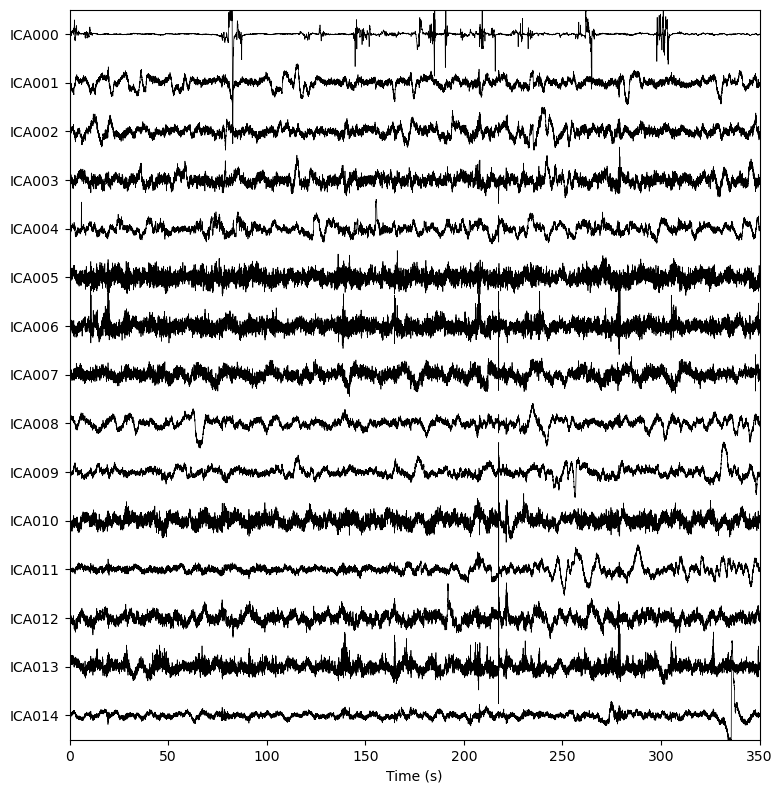

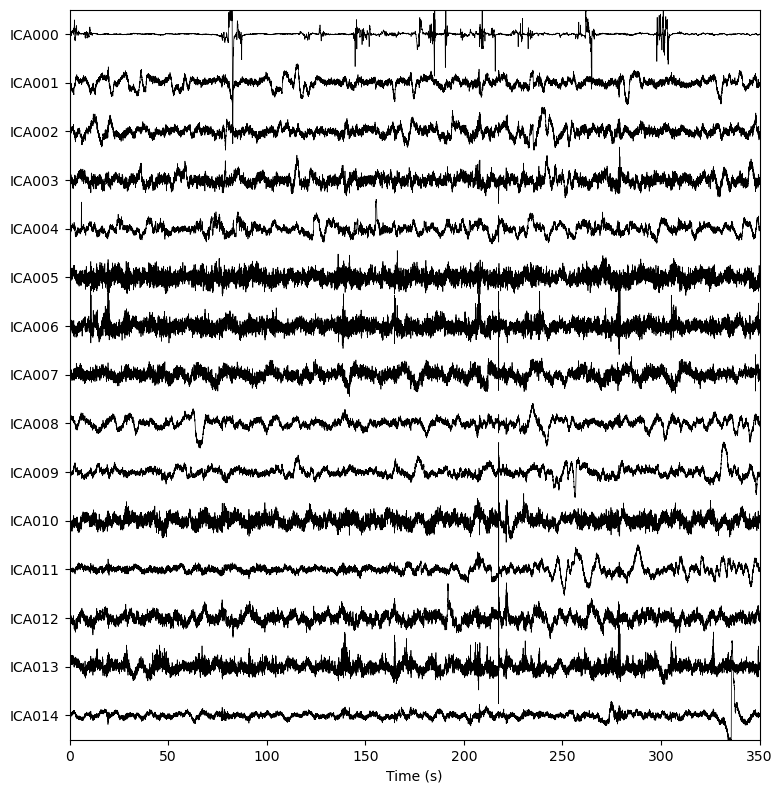

In [17]:
ica.plot_sources(filtered_eeg, show_scrollbars=False,start=0, stop=179217)
#ica.plot_sources(filtered_eeg, show_scrollbars=False,start=61440, stop=91260)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 15 PCA components


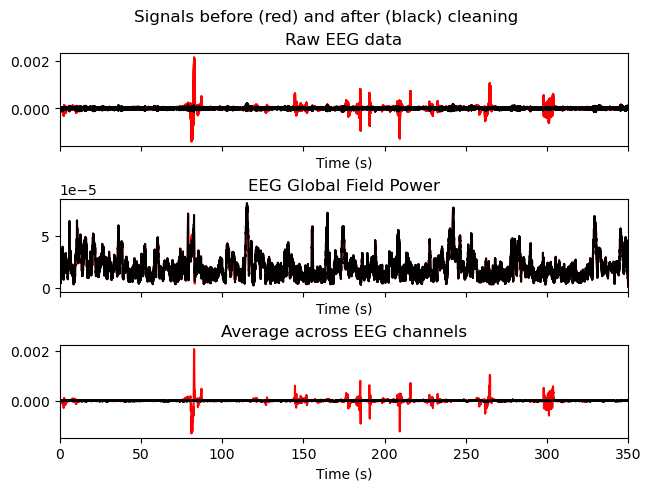

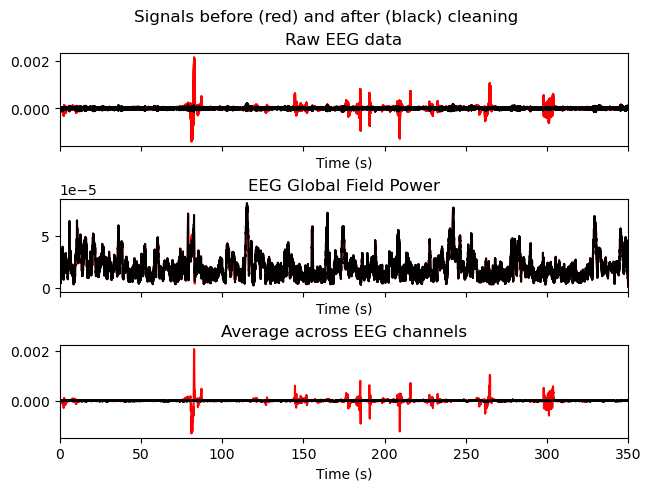

In [18]:
ica.plot_overlay(filtered_eeg, exclude=[0],start=0, stop=179217)

In [19]:
ica.exclude = [0]

In [20]:
icaed_eeg = filtered_eeg.copy()
ica.apply(icaed_eeg)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 15 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,15 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [87]:
# Plot bandpass and notch filtered data
eeg_df = icaed_eeg.to_data_frame(scalings=1e6)
eeg_df = eeg_df[(eeg_df['time']>0) & (eeg_df['time']<360)]
fig = px.line(eeg_df, x="time", y=eeg_df.columns[13],
              title='Filtered EEG Data from 15 Channels',
              labels={'value':u"\u03bcV"})

#fig.show()

In [51]:
icaed_eeg.info["sfreq"]

512.0

In [79]:
# There are two spectral estimation methods, Welch and Multitaper (uses DPSS tapers)
# Change n_fft for welch method to change the number of bins in each unit of frequency 
# n*icaed_eeg.info["sfreq"] -> n equal-width bins in each frequency
welch_psd = icaed_eeg.compute_psd(method='welch',n_fft=int(20*icaed_eeg.info["sfreq"]), fmin=0,fmax=30)
multitaper_psd = icaed_eeg.compute_psd(method='multitaper',fmin=0,fmax=30)

Effective window size : 20.000 (s)
    Using multitaper spectrum estimation with 1 DPSS windows


C:\Users\jimta\AppData\Local\Temp\ipykernel_30880\255351228.py:5: RuntimeWarning:

Could not properly use low_bias, keeping lowest-bias taper



In [77]:
welch_psd

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,15
Number of frequency bins,601
Frequency range,0.00 – 30.00 Hz


In [85]:
welch_psd_df = welch_psd.to_data_frame(copy=True)
welch_psd_df = welch_psd_df[(welch_psd_df['freq']>=0) & (welch_psd_df['freq']<3)]
# Scaling with 1e12 to micro-volt^2/Hz
for col in welch_psd_df.drop(['freq'],axis=1):
    welch_psd_df[col] = welch_psd_df[col]*1e12
fig = px.line(welch_psd_df, x="freq", y=welch_psd_df.columns,
              title='Delta band PSD from 15 Channels',
              labels={'value':u"\u03bcV<sup>2</sup>/Hz"})

#fig.show()

In [86]:
multitaper_psd_df = multitaper_psd.to_data_frame(copy=True)
multitaper_psd_df = multitaper_psd_df[(multitaper_psd_df['freq']>0) & (multitaper_psd_df['freq']<3)]
# Scaling with 1e12 to micro-volt^2/Hz
for col in multitaper_psd_df.drop(['freq'],axis=1):
    multitaper_psd_df[col] = multitaper_psd_df[col]*1e12
fig = px.line(multitaper_psd_df, x="freq", y=multitaper_psd_df.columns,
              title='Delta band PSD with multitaper method from 15 Channels',
              labels={'value':u"\u03bcV<sup>2</sup>/Hz"})

#fig.show()

In [22]:
# Square all eeg data
squared_eeg_list = []
for ch in icaed_eeg.ch_names:
    # Each channel 2 arrays (the data recorded, time in sec)
    #print((filtered_eeg[ch][0]))
    # Because the data cannot be replace inplace in the MNE RawArray
    # we need to create a new numpy array for the squared data 
    # and then convert it back to MNE RawArray
    squared_eeg_list.append(np.multiply(icaed_eeg[ch][0][0],1e6)**2)
    
squared_eeg_array = np.array(squared_eeg_list) 
squared_eeg = mne.io.RawArray(squared_eeg_array, eeg_info)

Creating RawArray with float64 data, n_channels=15, n_times=179218
    Range : 0 ... 179217 =      0.000 ...   350.033 secs
Ready.


In [90]:
# Plot 2 to 4-minute filtered and squared EEG data of channel 15 with Plotly
eeg_df = squared_eeg.to_data_frame(scalings=1)
eeg_df = eeg_df[(eeg_df['time']>100) & (eeg_df['time']<120)]
fig = px.line(eeg_df, x="time", y=eeg_df.columns,
              title='Squared EEG Data from 15 Channels',labels={'value':u"\u03bcV<sup>2</sup>"})
#fig.show()

#fig.write_html("raw_eeg.html")

In [24]:
eeg_df.head()

,time,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Channel13,Channel14,Channel15
51201,100.001953,1181.602282,100.006893,462.318261,2833.452557,494.386096,5.221481,2.647427,1991.938854,906.682201,5.631671,14.153895,3433.071823,146.485513,2901.697384,944.180833
51202,100.003906,1163.941745,97.946472,476.217317,2776.148490,492.106038,4.569114,2.097676,1944.465708,877.646327,3.963291,12.567739,3324.849363,149.806066,2694.974173,785.934899
51203,100.005859,1147.187732,95.549737,489.490852,2720.047012,492.433635,4.407369,1.750404,1894.968979,850.531770,3.365111,12.189146,3203.761972,156.410370,2474.134371,629.442100
51204,100.007812,1131.864383,92.805265,501.998281,2667.386017,494.883274,4.794679,1.649430,1845.044131,826.180096,3.748425,13.127950,3072.432415,166.966365,2245.861860,481.678345
51205,100.009766,1117.926754,89.683350,513.511315,2619.299361,498.667014,5.821480,1.829948,1796.123478,805.200449,5.290735,15.528660,2934.278649,181.827447,2017.790621,349.408434
